**다중회귀 (multiple regression)**    
여러개의 특성을 사용하는 회귀이다.

**특성 공학**    
특성을 조합하여 새로운 특성을 추가하거나, 특성을 변경하는 것이다.

### 데이터 준비

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('https://bit.ly/perch_csv')
perch_full = df.to_numpy()
print('특성:길이 높이 두께')
print(perch_full[0:2][:])

특성:길이 높이 두께
[[ 8.4   2.11  1.41]
 [13.7   3.53  2.  ]]


In [3]:
perch_weight = np.array(
    [5.9, 32.0, 40.0, 51.5, 70.0, 100.0, 78.0, 80.0, 85.0, 85.0, 
     110.0, 115.0, 125.0, 130.0, 120.0, 120.0, 130.0, 135.0, 110.0, 
     130.0, 150.0, 145.0, 150.0, 170.0, 225.0, 145.0, 188.0, 180.0, 
     197.0, 218.0, 300.0, 260.0, 265.0, 250.0, 250.0, 300.0, 320.0, 
     514.0, 556.0, 840.0, 685.0, 700.0, 700.0, 690.0, 900.0, 650.0, 
     820.0, 850.0, 900.0, 1015.0, 820.0, 1100.0, 1000.0, 1100.0, 
     1000.0, 1000.0]
     )

### 다항 특성 만들기

degree : 제곱항을 만들어준다.    
기본 값은 2라서 거듭제곱을 만들어준다.

In [4]:
from sklearn.preprocessing import PolynomialFeatures

# degree = 2
poly = PolynomialFeatures()
poly.fit([[2, 3]])

# 1(bias), 2, 3, 2**2, 2*3, 3**2
print(poly.transform([[2, 3]]))

[[1. 2. 3. 4. 6. 9.]]


### 다중회귀 모델 훈련하기

In [5]:
from sklearn.model_selection import train_test_split 

train_input, test_input, train_target, test_target = train_test_split(
    perch_full, perch_weight, random_state=42)

In [6]:
poly = PolynomialFeatures(include_bias = False)

poly.fit(train_input)
train_poly = poly.transform(train_input)
print(train_poly.shape)

(42, 9)


In [7]:
print(poly.get_feature_names())

test_poly = poly.transform(test_input)

['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression() 
lr.fit(train_poly, train_target) 

print(lr.score(train_poly, train_target))
print(lr.score(test_poly, test_target))

0.9903183436982124
0.9714559911594134


### 더 많은 특성 만들기
특성이 9개였는데 55개로 늘어났다.

In [9]:
poly = PolynomialFeatures(degree = 5, include_bias = False)

In [10]:
poly.fit(train_input)

train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)

print(train_poly.shape)

(42, 55)


특성이 너무 많을 경우 과대적합이 된다.    
과대적합이 될 경우 규제를 통해 과대적합을 완화한다.

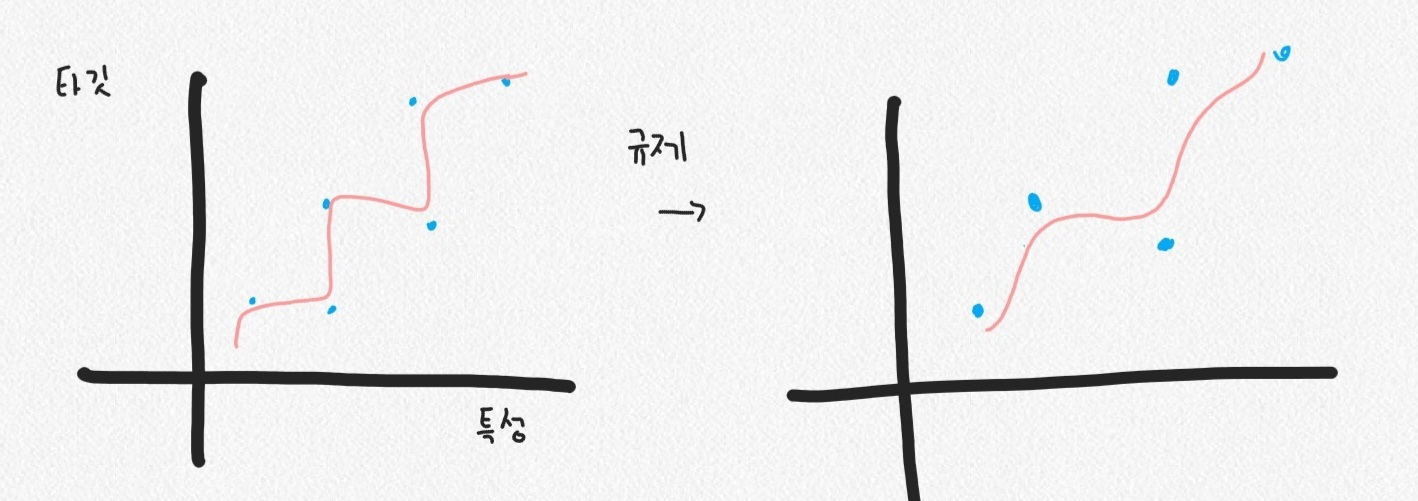

In [11]:
lr.fit(train_poly, train_target)

print(lr.score(train_poly, train_target))
print(lr.score(test_poly, test_target))

0.9999999999991097
-144.40579242684848


### 규제 전 표준화
규제는 가중치에 벌칙을 가하는 방식으로 가중치를 작게 만든다.     
규제를 공평하게 하려면 표준화를 해야한다.
             
StandardScaler : 표준점수로 변환

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
ss = StandardScaler()
ss.fit(train_poly)

train_scaled = ss.transform(train_poly)
test_scaled = ss.transform(test_poly)

### 릿지 회귀
릿지는 가중치의 제곱을 벌칙으로 사용한다. (=L2 규제)
     
규제 강도는 alpha를 사용하여 조절할 수 있고, 기본값은 1이다.

In [14]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(train_scaled, train_target)

print(ridge.score(train_scaled, train_target))
print(ridge.score(test_scaled, test_target))

0.9896101671037343
0.9790693977615397


### 적절한 규제 강도 찾기

In [15]:
import matplotlib.pyplot as plt

train_score = []
test_score = []
alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]

In [16]:
for alpha in alpha_list:
    # 릿지 모델 생성
    ridge = Ridge(alpha = alpha)
    # 릿지 모델 훈련
    ridge.fit(train_scaled, train_target)
    # 훈련 점수와 테스트 점수 저장
    train_score.append(ridge.score(train_scaled, train_target))
    test_score.append(ridge.score(test_scaled, test_target))

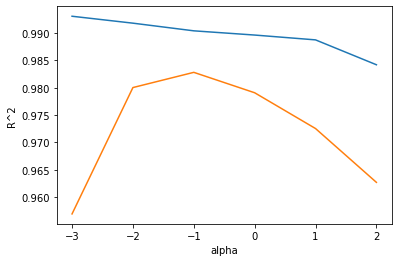

In [17]:
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()

In [18]:
ridge = Ridge(alpha = 0.1)
ridge.fit(train_scaled, train_target)

print(ridge.score(train_scaled, train_target))
print(ridge.score(test_scaled, test_target))

0.9903815817570366
0.9827976465386926


### 라쏘 회귀
라쏘 : 가중치의 절대값을 벌칙으로 준다. (L1규제)      
lasso는 특성을 사용하지 않을 수도 있다.

In [19]:
from sklearn.linear_model import Lasso

In [20]:
lasso = Lasso()
lasso.fit(train_scaled, train_target)

print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))

0.989789897208096
0.9800593698421883


In [21]:
train_score = []
test_score = []
alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]

In [22]:
for alpha in alpha_list: 
    lasso = Lasso(alpha = alpha, max_iter=10000)
    lasso.fit(train_scaled, train_target)

    train_score.append(lasso.score(train_scaled, train_target))
    test_score.append(lasso.score(test_scaled, test_target))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.878e+04, tolerance: 5.183e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.297e+04, tolerance: 5.183e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


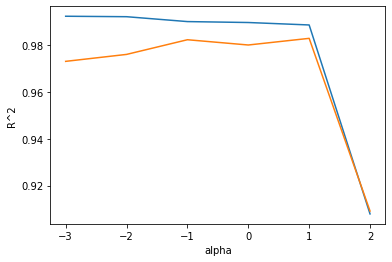

In [23]:
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()

In [24]:
lasso = Lasso(alpha = 10)
lasso.fit(train_scaled, train_target)

print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))

print(np.sum(lasso.coef_ == 0))

0.9888067471131867
0.9824470598706695
40
